## A Recommender System for Group Dining

We use users' review and rating information on restaurants to build a recommender system for group dining. It consists of the following steps:

* **Step 1**: use collaborative filtering to learn each user's preference over all restaurants. Given the high level of sparsity of the user-rating matrix, we use NLP method to extract information from reviews for each restaurant, and construct cosine distance matrix of all restaurants.

* **Step 2**: aggregate the group members' preference to form group preference, and further take into account individual constraint (none of the group members will be unhappy while maximizing the group's total dining experience), and geolocation constraint, recommend restaurants in the neighborhood.

### Datasets: obtained from Yelp
* 'restaurants.json': a subset of business.json within only restaurants
* 'photo.json': contains information of photo_id, caption, label, and business_id
* 'business.json': contain information of business, such as business_id, name, stars, address, etc.
* 'user.json': contain information of users

See <a href="https://www.yelp.com/dataset/download">Here</a> for a complete description of the data.

In [50]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.metrics.pairwise import pairwise_distances
from flaskexample import utility

## Starts from Here

In [181]:
review_restaurants_toronto = []
with open('review_restaurants_toronto.json') as file:
    for line in file:
        review_restaurants_toronto.append(json.loads(line))
review_restaurants_toronto_df = pd.DataFrame(review_restaurants_toronto)

#### Obtain List of Users with Many Reviews 

In [183]:
num_reviews_threshold = 30
user_review_count = review_restaurants_toronto_df.groupby(['user_id']).size().reset_index(name = 'counts')
user_review_count_subset = user_review_count[user_review_count['counts']>num_reviews_threshold]
user_id_with_many_reviews = user_review_count_subset['user_id'].reset_index(name = 'user_id')
user_id_list_with_many_reviews = list(user_id_with_many_reviews['user_id'])

#### Obtain List of Toronto Restaurants with Photos

In [206]:
restaurants_ids_toronto_df = pd.DataFrame({'business_id':list(review_restaurants_toronto_df['business_id'].unique())})

photo.json includes: photo_id: unique photo id; caption: some feature or dish of the restaurant; label: 'interior','food','outside','drink','menu'; business_id: unique business id

In [ ]:
photos = []
with open('photos.json') as file:
    for line in file:
        photos.append(json.loads(line))
photos_df = pd.DataFrame(photos)

Construct a dataframe that maps business_id to photo_id for Toronto restaurants. The order of 'food', 'outside', 'inside', 'drink', 'menu' is used if a restaurant has multiple photos. 

In [225]:
restaurant_id_photos_tmp = restaurants_ids_toronto_df.merge(photos_df, on='business_id', how='inner')[['business_id','label','photo_id']]#.drop_duplicates()
restaurant_id_photos_toronto = pd.DataFrame(restaurant_id_photos_tmp.groupby('business_id').apply(utility.select_photo))
restaurant_id_photos_toronto = restaurant_id_photos_toronto.rename(columns={restaurant_id_photos_toronto.columns[0]: 'photo_id'})

### Subsetting Reviews for Toronto Users with Many Reviews and Restaurants with Pictures
* Focus on users with many reviews to Alleviate the Severe Sparsity Problem for User-Restaurant Rating Matrix

In [223]:
review_restaurants_subset_toronto_with_picture_df = review_restaurants_toronto_df.loc[
    review_restaurants_toronto_df.apply(lambda x: x['user_id'] in user_id_list_with_many_reviews and x['business_id'] in restaurant_id_photos_toronto.index, axis = 1)]
review_restaurants_subset_toronto_with_picture_df.to_json('review_restaurants_subset_toronto_with_picture.json',orient='records',lines=True)

### Creating the user-item rating matrix

In [227]:
review_restaurants_subset_toronto_with_picture = []
with open('review_restaurants_subset_toronto_with_picture.json') as file:
    for line in file:
        review_restaurants_subset_toronto_with_picture.append(json.loads(line))
review_restaurants_subset_toronto_with_picture_df = pd.DataFrame(review_restaurants_subset_toronto_with_picture)

In [241]:
user_restaurant_ratings = review_restaurants_subset_toronto_with_picture_df.pivot(index='user_id', columns='business_id', values='review_stars')
user_restaurant_ratings.to_csv('user_restaurant_ratings')

Construct a dataframe that maps business_id to photo_id for our subset dataset. 

In [268]:
restaurant_id_photos_my_dataset = restaurant_id_photos_toronto[restaurant_id_photos_toronto.index.isin(list(user_restaurant_ratings.columns))]
restaurant_id_photos_my_dataset.reset_index(level=0, inplace=True)

## Starts From Here: Exploratory Analysis

## Need to scale down to the restaurants which has photos in the database

In [45]:
user_restaurant_ratings = pd.read_csv('user_restaurant_ratings', encoding = 'utf-8')
user_restaurant_ratings = user_restaurant_ratings.set_index('user_id')

num_review_per_user = user_restaurant_ratings.shape[1]-user_restaurant_ratings.isnull().sum(axis=1)

print('Number of Users :', user_restaurant_ratings.shape[0])
print('Number of Restaurants :', user_restaurant_ratings.shape[1])

print('Maximum number of reviews from one user : ', max(list(num_review_per_user)))
print('Minimum number of reviews from one user : ', min(list(num_review_per_user)))
print('Average number of reviews from one user : {0:.4f}'.format(np.mean(list(num_review_per_user))))

sparsity_ratio = sum(user_restaurant_ratings.isnull().sum())/(user_restaurant_ratings.shape[0]*user_restaurant_ratings.shape[1])
print('The sparsity ratio: {0:.4f}'.format(sparsity_ratio))

Number of Users : 1266
Number of Restaurants : 3518
Maximum number of reviews from one user :  641
Minimum number of reviews from one user :  16
Average number of reviews from one user : 53.9423
The sparsity ratio: 0.9847


In [47]:
# Replacing nan entries with 0
user_restaurant_ratings = user_restaurant_ratings.fillna(0)
##Creating a list of users, and a list of restaurants (these lists are in the same order as those in user_restaurant)
users_list = list(user_restaurant_ratings.index)
restaurants_list = list(user_restaurant_ratings.columns)

Construct a table containing information of restaurants in the toronto dataset

In [273]:
#restaurants_df = pd.DataFrame({'business_id':restaurants_list})
restaurants_info_my_dataset = restaurant_id_photos_my_dataset.merge(review_restaurants_subset_toronto_with_picture_df, 
                                                   on='business_id', how='inner')[['business_id','name','latitude',
                                                                                   'longitude','restaurant_stars','review_count',
                                                                                   'address','city','state','photo_id']].drop_duplicates()
restaurants_info_my_dataset.to_csv('restaurants_info_my_dataset.csv', index=False)

Construct a look-up table between user name and id

In [ ]:
users_df = pd.DataFrame({'user_id': users_list})
users_name_to_id = users_df.merge(user_df, on='user_id', how='inner')[['user_id','name']]
users_name_to_id.to_csv('users_name_to_id.csv', index=False)

Create Frequency Plots of Reviews by User and by Restaurant

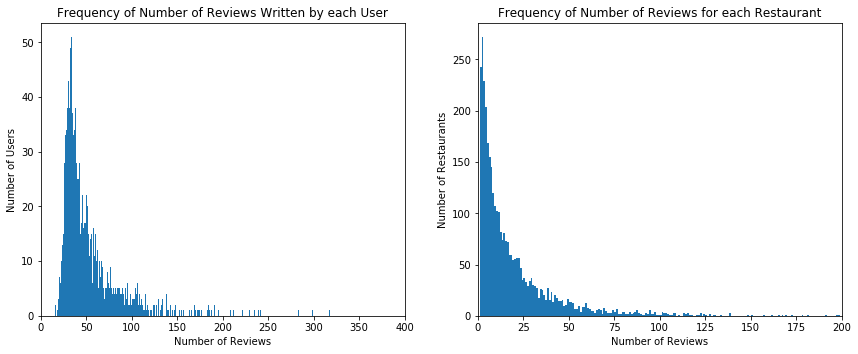

In [278]:
num_reviews_each_user = user_restaurant_ratings.astype(bool).sum(axis=1)
num_reviews_each_restaurant = user_restaurant_ratings.astype(bool).sum(axis=0)

%matplotlib inline
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(num_reviews_each_user, bins=np.arange(num_reviews_each_user.min(), num_reviews_each_user.max()+1))
plt.xlim(0,400)
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')
plt.title('Frequency of Number of Reviews Written by each User')

plt.subplot(1,2,2)
plt.hist(num_reviews_each_restaurant, bins=np.arange(num_reviews_each_restaurant.min(), num_reviews_each_restaurant.max()+1))
plt.xlim(0,200)
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Restaurants')
plt.title('Frequency of Number of Reviews for each Restaurant')
plt.tight_layout(pad=1, w_pad=2, h_pad=4.0)
plt.show()

## Collaborative Filtering

#### Construct the item-based similarity matrix from ratings. This matrix reflects cosine distance between restaurants in terms of quality (represented by rating). 

Cosine distance is invariant to the unit of measure. So even if the ratings for different restaurants are of different scale, it still makes sense. Not to mention that the ratings here are of the same scale 1-5.

In [282]:
restaurant_cosine_distance_from_ratings = pairwise_distances(user_restaurant_ratings.T, metric='cosine')
restaurant_cosine_distance_from_ratings = pd.DataFrame(restaurant_cosine_distance_from_ratings)
restaurant_cosine_distance_from_ratings.columns = restaurants_list
restaurant_cosine_distance_from_ratings.to_csv('restaurant_cosine_distance_from_ratings.csv',index=False)

In [40]:
restaurant_cosine_distance_from_ratings = pd.read_csv('restaurant_cosine_distance_from_ratings.csv')
restaurant_cosine_distance_from_ratings = restaurant_cosine_distance_from_ratings.as_matrix()

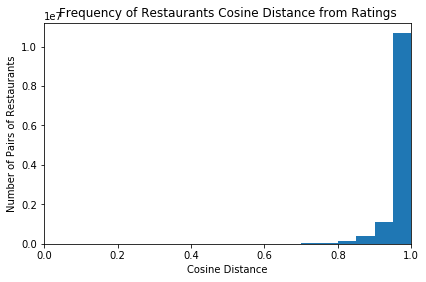

In [284]:
restaurant_cosine_distance_from_ratings_flattened = restaurant_cosine_distance_from_ratings.flatten()

%matplotlib inline
plt.figure(figsize=(6,4))
plt.hist(restaurant_cosine_distance_from_ratings_flattened, bins=20)
plt.xlim(0,1)
plt.xlabel('Cosine Distance')
plt.ylabel('Number of Pairs of Restaurants')
plt.title('Frequency of Restaurants Cosine Distance from Ratings')
plt.tight_layout(pad=1, w_pad=2, h_pad=4.0)
plt.show()

#### Comment
The histogram is highly concentrated at 1, and this implies that the restaurants are very independent. The rating matrix does not provide us enough information to learn the similarity among all the restaurants. Numerically, since we have a lot of zeros in the rating matrix, then the inner product of two vectors are either zero or close to zero. As a result, we need to resort to other information source.

## Constructing Distance Matrix between Restaurants Using Reviews

#### 1. Pre-processing the reviews 

In [37]:
import nltk
#nltk.download()

#### Remove punctuations from reviews

In [38]:
from nltk.tokenize import RegexpTokenizer  #Regular-Expression Tokenizers
tokenizer = RegexpTokenizer(r'\w+')  #symbol in red means different tokenization choices, here we remove punctuations from reviews

In [286]:
review_grouped_by_restaurants = review_restaurants_subset_toronto_with_picture_df.groupby('business_id')['text'].apply(lambda x: "{%s}" % ' '.join(x))
review_grouped_by_restaurants_tokenized = review_grouped_by_restaurants.apply(lambda x: ' '.join(tokenizer.tokenize(x)))
reviews_restaurants_tokenized = list(review_grouped_by_restaurants_tokenized)

### Remove stopwords and stem the words
* Remove Stopwords such as 'a', 'the', 'again', etc. There are 179 stopwords in stop_words
* Stem the words: Stemmers remove morphological affixes from words, leaving only the word stem. For example, enjoying --> enjoy, etc

In [287]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Remove stop words and Get word stem
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english") # Choose a language

texts = [[stemmer.stem(word) for word in review.lower().split() if (word not in stop_words)] 
         for review in reviews_restaurants_tokenized]
#texts is a list of lists, each element is the list of words from all the reviews of a restaurant, in the same order
#as the words in review.

#### 2. Creating the dictionary
The dictionary consists of a concatenation of unique words of all reviews. Gensim is an efficient library to analyse the latent semantic similarity between documents. 

In [288]:
from gensim import corpora, models, similarities
dictionary = corpora.Dictionary(texts)

In [289]:
len(dictionary)

48994

In [290]:
import itertools
print("A sample of the dictionary")
list(itertools.islice(dictionary.token2id.items(), 59, 69))

A sample of the dictionary


[('fill', 59),
 ('find', 60),
 ('food', 61),
 ('forward', 62),
 ('fresh', 63),
 ('fri', 64),
 ('friend', 65),
 ('fun', 66),
 ('gastro', 67),
 ('get', 68)]

This function maps unique words with their ids. In our case, the dictionary consists of 53801 words which means that each review will be represented through a 53801-dimensional vector space. 

In [126]:
from os import path

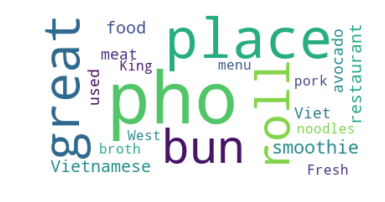

In [163]:
from wordcloud import WordCloud, STOPWORDS
stopwords_wordcloud = set(STOPWORDS)

wc = WordCloud(background_color="white", max_words=20, stopwords=stopwords_wordcloud)
# generate word cloud
wc.generate(reviews_restaurants_tokenized[28])

wc.to_file(path.join("/home/heming611/Insight/Yelp-Project", "alice.png"))

# show
%matplotlib inline
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
#plt.imshow(alice_mask, cmap=plt.cm.gray, interpolation='bilinear')
#plt.axis("off")
plt.show()

#### 3 Creating the corpus
The corpus is the collection of all reviews pre-processed and transformed using the dictionary. 

In [291]:
corpus = [dictionary.doc2bow(text) for text in texts] #doc2bow is documenty to bag of words

Lengths of different elements in corpus are different corpus only count frequencies of words in reviews for 
different restaurants if the word appears at least once. Conceptually, we can still understand each restaurant
to be represented by a long vector, each entry representing the word frequeny following order in the dictionary. 

In [292]:
print('length of corpus for restaurant 1:',len(corpus[0]))
print('length of corpus for restaurant 2:',len(corpus[1]))

length of corpus for restaurant 1: 200
length of corpus for restaurant 2: 628


In [293]:
print(corpus[1][:4])
#The vector feature (1, 1) means that the word with id=1 appears once in the entire corpus[1] (all reviews for restaurant 2). 

[(1, 2), (3, 11), (4, 1), (5, 1)]


#### 4. Creating the tf-idf transformation

In [294]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [295]:
print('length of corpus_tfidf for restaurant 1:',len(corpus_tfidf[0]))
print('length of corpus_tfidf for restaurant 2:',len(corpus_tfidf[1]))

length of corpus_tfidf for restaurant 1: 200
length of corpus_tfidf for restaurant 2: 628


In [296]:
print(corpus_tfidf[1][:4])

[(1, 0.004538517621693482), (3, 0.023497475555596475), (4, 0.00678886390774615), (5, 0.009966852020391269)]


#### 5 Choice of the number of topics
As mentioned above, LSA seeks to identify a set of topics related to the restaurants reviews. The number of these topics N is equal to the dimension of the approximation matrix resulting from the SVD dimension reduction technique. This number is a hyper-parameter to be carefully adjusted. It results from the selection of the N largest singular values of the tf-idf corpus matrix. These singular values can be calculated as follows: 

In [297]:
import gensim
corpus_dense_matrix = gensim.matutils.corpus2dense(corpus, num_terms=len(dictionary), num_docs=len(texts))
corpus_dense_matrix.shape

(48994, 3518)

In [298]:
s = np.linalg.svd(corpus_dense_matrix, full_matrices=False, compute_uv=False)

In [30]:
s.shape

(6257,)

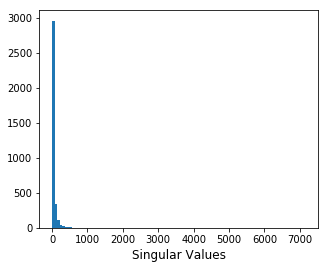

In [299]:
#A histogram of the singular values of the tf-idf corpus matrix is presented in the following figure. 
plt.figure(figsize=(5,4))
plt.hist(s, bins=100)
plt.xlabel('Singular Values', fontsize=12)
plt.show()

**Use SVD for Low-rank matrix approximation**

To approximate a matrix $M$ with another matrix $\widehat{M}$ with rank $r$. It turns out that

$$\mathop{\arg\min}\limits_{\widehat{M},\text{ rank}(\widehat{M})=r} \big|\big|M-\widehat{M}\big|\big|=U \widehat{\Sigma}V^*,$$
where $||\cdot||$ is the Frobenius norm, $\widehat{\Sigma}$ is the same matrix as $Σ$ except that it contains only the $r$ largest singular values (the other singular values are replaced by zero). This is known as the **Eckart–Young theorem**, as proved by those two authors in 1936.

* The singular-value decomposition of an $m\times n$ matrix $M$ is a factorization of the form $M=U\Sigma V^{*}$, where $U$ is an $m\times m$ real or complex unitary matrix, $\Sigma$ is a $m\times n$ *rectangular* diagonal matrix with non-negative real numbers on the diagonal, $V$ is an $n\times n$ real or complex unitary matrix, and $V^*$ is the conjugate transpose of $V$. The diagonal entries $\sigma _{i}$ of $\Sigma$ are the singular values of $M$. The columns of $U$ and the columns of $V$ are called the left-singular vectors and right-singular vectors of $M$, respectively. 

* A unitary matrix is one whose conjugate transpose is also its inverse. The conjugate transpose of a matrix $A$ is obtained by taking the transpose of $A$ and then taking the complex conjugate of each entry.

#### 6 Creating the LSA model

In [300]:
restaurant_types = ['Japanese','Pizza','Mexican','Chinese','Thai','Italian','Seafood','Burgers','Korean',
                  'Steakhouses','Vegetarian','Sushi Bars','Sandwiches','Vietnamese','American (New)']

In [301]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=len(restaurant_types))
#The "LsiModel" function transforms our tf-idf corpus into a latent 15-dimensional space (number of topics = 15).
cosine_similarity = similarities.docsim.MatrixSimilarity(lsi[corpus_tfidf]) # transform corpus to LSI space and index it
# cosine_similarity = similarities.MatrixSimilarity(lsi[corpus_tfidf])

In [302]:
restaurant_cosine_distance_from_reviews = 1-np.array(cosine_similarity)
pd.DataFrame(restaurant_cosine_distance_from_reviews).to_csv('restaurant_cosine_distance_from_reviews.csv',index=False)

In [43]:
restaurant_cosine_distance_from_reviews = pd.read_csv('restaurant_cosine_distance_from_reviews.csv')

In [59]:
#lsi.show_topics()

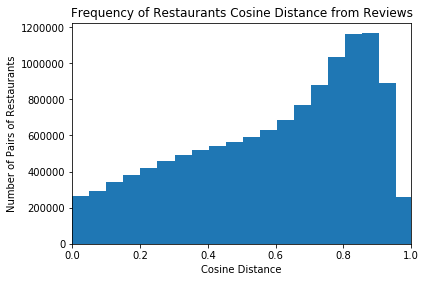

In [305]:
restaurant_cosine_distance_from_reviews_flattened = restaurant_cosine_distance_from_reviews.flatten()

%matplotlib inline
plt.figure(figsize=(6,4))
plt.hist(restaurant_cosine_distance_from_reviews_flattened, bins=30)
plt.xlim(0,1)
plt.xlabel('Cosine Distance')
plt.ylabel('Number of Pairs of Restaurants')
plt.title('Frequency of Restaurants Cosine Distance from Reviews')
plt.tight_layout(pad=1, w_pad=2, h_pad=4.0)
plt.show()

### Construct Different Models and CF-filled Matrices by Varying the Weights on Two Similarity Matrices
Use CF to fill out the user_restaurant matrix, use the item-based similarity matrix, and store them for later use

In [ ]:
alphas = list(np.arange(0.1, 1, 0.1)) # alpha is the weight on the restaurant_distance_from_ratings matrix
models = list(np.arange(1,10,1))
for (alpha, model) in zip(alphas, models):
    restaurant_cosine_distance_hybrid = alpha*restaurant_cosine_distance_from_ratings+(1-alpha)*restaurant_cosine_distance_from_reviews
    restaurant_cosine_distance_hybrid = pd.DataFrame(restaurant_cosine_distance_hybrid)
    restaurant_cosine_distance_hybrid.columns = restaurants_list
    user_restaurant_cf = utility.predicted_rating(user_restaurant_ratings.as_matrix(), restaurant_cosine_distance_hybrid, type='item') # Type: matrix
    user_restaurant_cf_df_model = pd.DataFrame(data=user_restaurant_cf, index=users_list, columns=restaurants_list)
    user_restaurant_cf_df_model.to_csv('user_restaurant_cf_model_' + str(model) +'.csv')

### Lower-Dimensional Data Visualization of Users' Preference
Use PCA to project users ratings (in Toronto) on the plane, using a hybrid model with weight 0.5

In [3]:
user_restaurant_cf = pd.read_csv('user_restaurant_cf_model_'+str(5)+'.csv')
user_restaurant_cf = user_restaurant_cf.rename(columns = {'Unnamed: 0':'user_id'})
user_restaurant_cf = user_restaurant_cf.set_index('user_id')

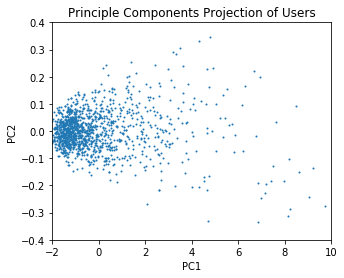

In [314]:
from sklearn import decomposition
from sklearn.decomposition import PCA

pca = decomposition.PCA(n_components=2)
pca.fit(user_restaurant_cf.as_matrix())
user_pca = pca.transform(user_restaurant_cf)
# user_pca is a list of pairs of (x,y) coordinates, x: 1st principle component, y: 2nd principle component

plt.figure(figsize=(5,4))
plt.scatter(user_pca[:,0],user_pca[:,1],s=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axis((-2,10,-0.4,0.4))
plt.title('Principle Components Projection of Users')
plt.show()

## Recommending Restaurants

#### Compute Business ids with Distance Constraint

In [8]:
from geopy.distance import great_circle

#Specify mile limit and default location
within_x_miles = 1
latitude_default, longitude_default = 43.6544, -79.3807 # Toronto Eaton Centre
my_location = (latitude_default, longitude_default)

#Filter out business_id within the mile limit
restaurants_info_my_dataset = pd.read_csv('restaurants_info_my_dataset.csv')
distances_to_my_location = restaurants_info_my_dataset.apply(lambda x: great_circle(np.array(x[['latitude','longitude']]), my_location).miles, axis=1) 
restaurants_info_my_dataset['distances_to_my_location'] = distances_to_my_location
restaurants_info_my_dataset = restaurants_info_my_dataset.set_index('business_id')
business_id_within_x_miles = list(restaurants_info_my_dataset[np.array(restaurants_info_my_dataset['distances_to_my_location'])<=within_x_miles].index)

Import look up table for user id and name

In [9]:
users_name_to_id = pd.read_csv('users_name_to_id.csv')

Convert list of user names to list of user id for the group

In [10]:
group_name_list = ['Stephen','Nisha','Dixie']
group_id_df = users_name_to_id[users_name_to_id.apply(lambda x : x['name'] in group_name_list, axis = 1)].drop_duplicates(subset='name')
group_id_list = list(group_id_df['user_id'])

Recommend restaurants for different models with different weights between two types of restaurants similarity matrix

In [31]:
model_choices = np.arange(1,10,4)
quantile_threshold = 0.25
select_top_x = 5
results = utility.group_restaurant_recommendation(model_choices, business_id_within_x_miles, 
                                                  group_id_list, quantile_threshold, 
                                                  select_top_x, restaurants_info_my_dataset)
   
list_of_business_ids_different_models = results[0]
list_of_photo_ids_different_models = results[1]
list_of_business_names_different_models = results[2]
list_of_business_stars_different_models = results[3]
list_of_business_review_count_different_models = results[4] 
list_of_business_address_different_models = results[5]
list_of_business_distance_different_models = results[6]
random_choice_list = results[7]

### Print Recommended Restaurants from Different Models

In [32]:
recommendations_different_models = []
column_list = ['Restaurant Name', 'Star Rating', 'Address', 'Distance']

for i in range(len(model_choices)):
    #print (i)
    name = list_of_business_names_different_models[i]
    stars = list_of_business_stars_different_models[i]
    address = list_of_business_address_different_models[i]
    distance = list_of_business_distance_different_models[i]
    df = pd.DataFrame({'Restaurant Name': name,
                       'Star Rating': stars,
                       'Address': address,
                       'Distance': distance
                      })
    recommendations_different_models.append(df[column_list])

In [33]:
print('Recommended Restaurants from Model 1 (weight = 0.1)')
recommendations_different_models[0]

Recommended Restaurants from Model 1 (weight = 0.1)


,Restaurant Name,Star Rating,Address,Distance
0,Si Lom Thai Bistro,4.0,"534 Church Street,Toronto,ON",0.7
1,Yummy Yummy Dumplings,4.0,"79 Huron Street,Toronto,ON",0.8
2,Thai Country Kitchen,4.0,"412 Spadina Ave,Toronto,ON",1.0
3,Thai Fantasy,4.0,"578 Yonge Street,Toronto,ON",0.8
4,Thai Noodle,4.0,"147 Baldwin Street,Toronto,ON",0.9


In [34]:
print('Recommended Restaurants from Model 2 (weight = 0.5)')
recommendations_different_models[1]

Recommended Restaurants from Model 2 (weight = 0.5)


,Restaurant Name,Star Rating,Address,Distance
0,Si Lom Thai Bistro,4.0,"534 Church Street,Toronto,ON",0.7
1,Fudao noodle house,4.0,"358 Spadina ave,Toronto,ON",0.9
2,Panpan Noodle Bar,4.0,"23 Baldwin Street, 2nd Floor,Toronto,ON",0.6
3,Thai Fantasy,4.0,"578 Yonge Street,Toronto,ON",0.8
4,Thai Noodle,4.0,"147 Baldwin Street,Toronto,ON",0.9


In [35]:
print('Recommended Restaurants from Model 3 (weight = 0.9)')
recommendations_different_models[2]

Recommended Restaurants from Model 3 (weight = 0.9)


,Restaurant Name,Star Rating,Address,Distance
0,Papa Spicy,4.5,"339 Spadina Avenue,Toronto,ON",0.9
1,Fudao noodle house,4.0,"358 Spadina ave,Toronto,ON",0.9
2,Carribean Queen Metro,4.0,"10 Dundas Street,Toronto,ON",0.1
3,Kaiseki-Sakura,4.5,"556 Church St,Toronto,ON",0.8
4,Panpan Noodle Bar,4.0,"23 Baldwin Street, 2nd Floor,Toronto,ON",0.6


Dataset needs to be uploaded to github

* restaurants_info_my_dataset.csv
* users_name_to_id.csv
* user_restaurant_cf_model_' + str(model) +'.csv
* restaurant_cosine_distance_from_reviews
* restaurant_cosine_distance_from_ratings